In [1]:
### Import
import pickle
import cv2
import math
import time
import h5py
import json
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


In [2]:
### Load data

# Read in CSV file
csv_loc = "data_mine/driving_log.csv"
df = pd.read_csv(csv_loc)

# Drop 75% of Steering Angles with value = 0
df = df.drop(df[df['steering'] == 0].sample(frac=0.75).index)

# Add c,l and r images.
features_col = pd.concat([df['center'], df['left'].map(str.strip), df['right'].map(str.strip)])
features_col = np.array(features_col.values.tolist())

# Format image path in CSV
features_col_new = []
for idx in range(len(features_col)):
    tmp = list(features_col[idx])
    tmp[139] = "/"
    features_col_new.append("".join(tmp))
features_col_new = np.array(features_col_new)

# Add steering angles for c,l,r with added shift for l and r images
l_shift = 0.25
r_shift = -0.25
labels_c = df['steering']
labels_r = df['steering'] + r_shift
labels_l = df['steering'] + l_shift
labels_col = pd.concat([labels_c, labels_l, labels_r])
labels_col = np.array(labels_col.values.tolist())

print("Length of Features: {0}, Labels: {1}".format(len(features_col_new), len(labels_col)))

# Split csv data
features_col, labels_col = shuffle(features_col_new, labels_col)
X_train, X_val, y_train, y_val = train_test_split(features_col, labels_col, test_size=0.15, random_state=42232) 

# Read in image list
images = os.listdir("data_mine/IMG/")

Length of Features: 1785, Labels: 1785


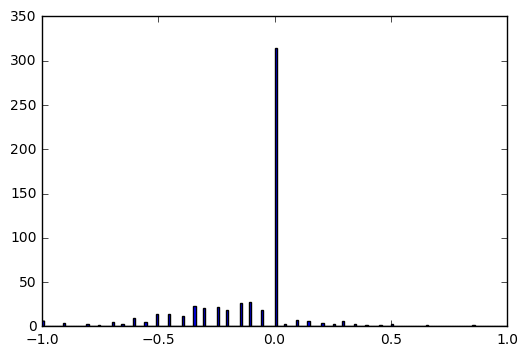

In [3]:
### Plot data
plt.hist(df['steering'],bins=200, range=(-1,1));

In [4]:
### Pre-Process
img_cols = 32
img_rows = 16

def data_trans(image, label):
    trans_factor = 30*np.random.uniform() - 15 # Parameters set based on original image dimensions
    trans_matrix = np.float32([[1,0,trans_factor],[0,1,trans_factor]])
    image_trans = cv2.warpAffine(image,trans_matrix,(image.shape[1],image.shape[0]))

    label = label + (2*0.4*trans_factor)/60
    #print(label)
    
    return image_trans, label
    
    
def preprocess_data(image, label, flag):
    # Crop Image
    image = image[60:140,:]
      
    # HSV
    image = (cv2.cvtColor(image, cv2.COLOR_RGB2HSV))[:,:,1]
    
    # Resize
    image = cv2.resize(image, (img_cols, img_rows))
    
    # Translate image and steering angle
    if flag == "TRAIN":
        #image, label = data_trans(image, label)
        pass
    
    return image, label

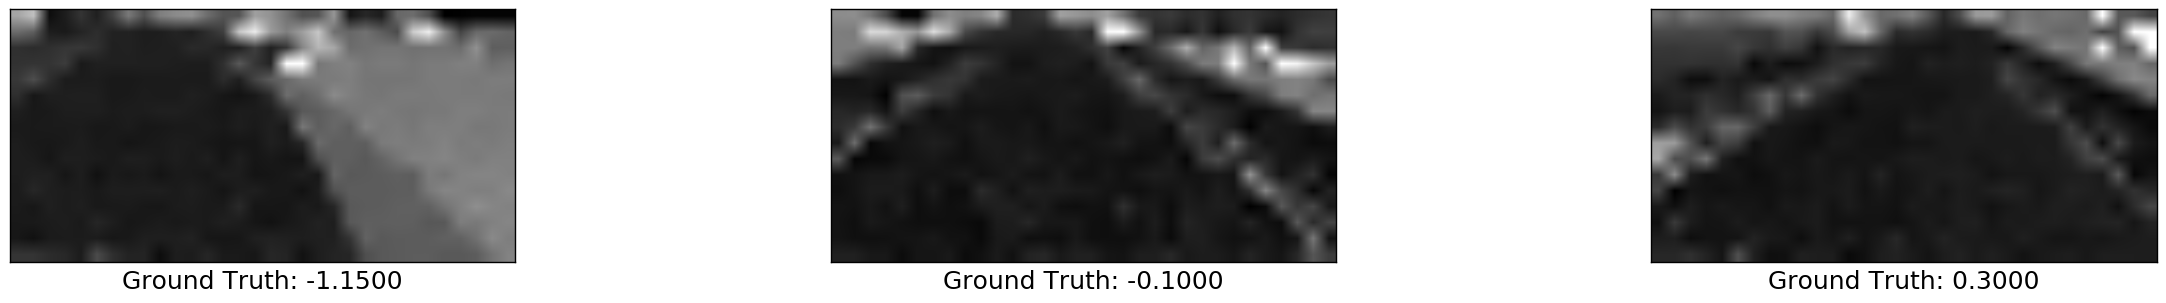

In [5]:
### Plot random images
fig = plt.figure(figsize=(30, 15))

for i in range(3):
    image_seq = np.random.randint(1,len(X_train))
    image = mpimg.imread("data_mine/" + X_train[image_seq][136:])
    
    image, label = preprocess_data(image, y_train[image_seq], "TRAIN")
    
    img = fig.add_subplot(4,3,i+1)
    plt.imshow(image, cmap='gray')
    img.set_xlabel("Ground Truth: {0:.4f}".format(y_train[image_seq]),fontsize=18)
    img.set_xticks([])
    img.set_yticks([])

plt.show()



In [6]:
### Helper Functions

def image_generator(csv_features, csv_labels, flag):
    csv_features, csv_labels = shuffle(csv_features, csv_labels)
    
    for idx in range(len(csv_features)):
        
        label = csv_labels[idx]
        
        image = mpimg.imread("data_mine/" + csv_features[idx][136:])
        image, label = preprocess_data(image, label, flag)
        
        # Reshape
        image = image.reshape((img_rows, img_cols) + (1,))
        yield image, label

def train_data_generator(csv_features, csv_labels, batch_size):
    num_rows = int(len(csv_features))
    ctr = None
    batch_x = np.zeros((batch_size, img_rows, img_cols, 1))
    batch_y = np.zeros(batch_size)
    while True:
        
        for i in range(batch_size):
            
            if ctr is None or ctr >= num_rows:
                ctr = 0
                images = image_generator(csv_features, csv_labels, "TRAIN")
            batch_x[i], batch_y[i] = next(images)
            ctr += 1

        yield (batch_x, batch_y)

def valid_data_generator(csv_features, csv_labels, batch_size):
    num_rows = int(len(csv_features))
    ctr = None
    batch_x = np.zeros((batch_size, img_rows, img_cols, 1))
    batch_y = np.zeros(batch_size)
    while True:
        
        for i in range(batch_size):
            
            if ctr is None or ctr >= num_rows:
                ctr = 0
                images = image_generator(csv_features, csv_labels, "VALID")
            batch_x[i], batch_y[i] = next(images)
            ctr += 1
        
        yield (batch_x, batch_y)

In [7]:
### Parameters
layer_1_depth = 16
layer_2_depth = 32

filter_size_1 = 5
filter_size_2 = 3

num_neurons_1 = 32

epochs = 20
batch_size = 64

samples_per_epoch = X_train.shape[0]

In [8]:
### Model
model = Sequential()
model.add(Lambda(lambda x: x/255.-0.5,input_shape = (img_rows, img_cols, 1)))
model.add(Convolution2D(layer_1_depth, filter_size_1, filter_size_1, border_mode = 'valid', subsample = (1,1)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(layer_2_depth, filter_size_2, filter_size_2, border_mode = 'valid', subsample = (1,1)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(num_neurons_1))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.summary()

model.compile(loss='mse',
              optimizer=Adam(lr = 0.0001),
              metrics=['mean_absolute_error'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 16, 32, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 12, 28, 16)    416         lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 12, 28, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 6, 14, 16)     0           activation_1[0][0]               
___________________________________________________________________________________________

In [9]:
### Train model
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=0, 
                                            save_best_only=True, save_weights_only=False, mode='auto')

history = model.fit_generator(train_data_generator(X_train, y_train, batch_size),
                              samples_per_epoch=samples_per_epoch,
                              nb_epoch = epochs,
                              verbose = 1, callbacks = [checkpoint],
                              validation_data = valid_data_generator(X_val, y_val, batch_size),
                              nb_val_samples=X_val.shape[0], pickle_safe=True)

Epoch 1/20
1472/1517 [============================>.] - ETA: 0s - loss: 0.1004 - mean_absolute_error: 0.2452

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1536/1517 [==============================] - 5s - loss: 0.1016 - mean_absolute_error: 0.2467 - val_loss: 0.0842 - val_mean_absolute_error: 0.2240
Epoch 2/20
1536/1517 [==============================] - 2s - loss: 0.0868 - mean_absolute_error: 0.2300 - val_loss: 0.0699 - val_mean_absolute_error: 0.2070
Epoch 3/20
1536/1517 [==============================] - 2s - loss: 0.0717 - mean_absolute_error: 0.2042 - val_loss: 0.0606 - val_mean_absolute_error: 0.1955
Epoch 4/20
1536/1517 [==============================] - 2s - loss: 0.0678 - mean_absolute_error: 0.1985 - val_loss: 0.0583 - val_mean_absolute_error: 0.1891
Epoch 5/20
1536/1517 [==============================] - 2s - loss: 0.0582 - mean_absolute_error: 0.1830 - val_loss: 0.0566 - val_mean_absolute_error: 0.1842
Epoch 6/20
1536/1517 [==============================] - 2s - loss: 0.0619 - mean_absolute_error: 0.1860 - val_loss: 0.0561 - val_mean_absolute_error: 0.1828
Epoch 7/20
1536/1517 [==============================] - 2s - loss: 0.